# **Homework 1: Linear Regression**

本次目標：由前 9 個小時的 18 個 features (包含 PM2.5)預測的 10 個小時的 PM2.5。<!-- 可以參考 <link> 獲知更細項的作業說明。-->

<!-- 首先，從 https://drive.google.com/open?id=1El0zvTkrSuqCTDcMpijXpADvJzZC2Jpa 將整個資料夾下載下來，並將下載下來的資料夾放到自己的 Google Drive（注意：上傳到自己 Google Drive 的是資料夾 hw1-regression，而非壓縮檔） -->


若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

# **Load 'train.csv'**
train.csv 的資料為 12 個月中，每個月取 20 天，每天 24 小時的資料(每小時資料有 18 個 features)。

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive 
!gdown --id '1wNKAxQ29G15kgpBy_asjTcZRRgmsCZRm' --output data.zip
!unzip data.zip
# data = pd.read_csv('gdrive/My Drive/hw1-regression/train.csv', header = None, encoding = 'big5')
data = pd.read_csv('./train.csv', encoding = 'big5')

Permission denied: https://drive.google.com/uc?id=1wNKAxQ29G15kgpBy_asjTcZRRgmsCZRm
Maybe you need to change permission over 'Anyone with the link'?
unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


In [3]:
data = pd.read_csv('./train.csv', encoding = 'big5')

# **Preprocessing** 
取需要的數值部分，將 'RAINFALL' 欄位全部補 0。
另外，如果要在 colab 重覆這段程式碼的執行，請從頭開始執行(把上面的都重新跑一次)，以避免跑出不是自己要的結果（若自己寫程式不會遇到，但 colab 重複跑這段會一直往下取資料。意即第一次取原本資料的第三欄之後的資料，第二次取第一次取的資料掉三欄之後的資料，...）。

In [4]:
data = data.iloc[:, 3:]
data[data == 'NR'] = 0
raw_data = data.to_numpy()

# **Extract Features (1)**
![圖片說明](https://drive.google.com/uc?id=1LyaqD4ojX07oe5oDzPO99l9ts5NRyArH)
![圖片說明](https://drive.google.com/uc?id=1ZroBarcnlsr85gibeqEF-MtY13xJTG47)

將原始 4320 * 18 的資料依照每個月分重組成 12 個 18 (features) * 480 (hours) 的資料。 

In [5]:
month_data = {}
for month in range(12):
    sample = np.empty([18, 480]) # 18 datas each day
    for day in range(20): # only 20 days per months
        # 24 hours
        sample[:, day * 24 : (day + 1) * 24] = raw_data[18 * (20 * month + day) : 18 * (20 * month + day + 1), :]
    month_data[month] = sample

# **Extract Features (2)**
![alt text](https://drive.google.com/uc?id=1wKoPuaRHoX682LMiBgIoOP4PDyNKsJLK)
![alt text](https://drive.google.com/uc?id=1FRWWiXQ-Qh0i9tyx0LiugHYF_xDdkhLN)

每個月會有 480hrs，每 9 小時形成一個 data，每個月會有 471 個 data，故總資料數為 471 * 12 筆，而每筆 data 有 9 * 18 的 features (一小時 18 個 features * 9 小時)。

對應的 target 則有 471 * 12 個(第 10 個小時的 PM2.5)

In [6]:
x = np.empty([12 * 471, 18 * 9], dtype = float)
y = np.empty([12 * 471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14: #20days:0-19, 24hours:0-23, only support 471 index = 19*24 + 24-9
                continue
            x[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
            y[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value 9th is PM2.5 in features
print(x) #5652x162
print(y) #5652x1

[[14.  14.  14.  ...  2.   2.   0.5]
 [14.  14.  13.  ...  2.   0.5  0.3]
 [14.  13.  12.  ...  0.5  0.3  0.8]
 ...
 [17.  18.  19.  ...  1.1  1.4  1.3]
 [18.  19.  18.  ...  1.4  1.3  1.6]
 [19.  18.  17.  ...  1.3  1.6  1.8]]
[[30.]
 [41.]
 [44.]
 ...
 [17.]
 [24.]
 [29.]]


# **Normalize (1)**


In [7]:
mean_x = np.mean(x, axis = 0) #18 * 9 
std_x = np.std(x, axis = 0) #18 * 9 
for i in range(len(x)): #12 * 471
    for j in range(len(x[0])): #18 * 9 
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]
x

array([[-1.35825331, -1.35883937, -1.359222  , ...,  0.26650729,
         0.2656797 , -1.14082131],
       [-1.35825331, -1.35883937, -1.51819928, ...,  0.26650729,
        -1.13963133, -1.32832904],
       [-1.35825331, -1.51789368, -1.67717656, ..., -1.13923451,
        -1.32700613, -0.85955971],
       ...,
       [-0.88092053, -0.72262212, -0.56433559, ..., -0.57693779,
        -0.29644471, -0.39079039],
       [-0.7218096 , -0.56356781, -0.72331287, ..., -0.29578943,
        -0.39013211, -0.1095288 ],
       [-0.56269867, -0.72262212, -0.88229015, ..., -0.38950555,
        -0.10906991,  0.07797893]])

#**Split Training Data Into "train_set" and "validation_set"**
這部分是針對作業中 report 的第二題、第三題做的簡單示範，以生成比較中用來訓練的 train_set 和不會被放入訓練、只是用來驗證的 validation_set。

In [8]:
def shullfeData(x, y):
  index = np.random.permutation(x.shape[0])
  x = x[index,:]
  y = y[index,:]
  x_train_set = x[: math.floor(len(x) * 0.8), :]
  y_train_set = y[: math.floor(len(y) * 0.8), :]
  x_validation = x[math.floor(len(x) * 0.8): , :]
  y_validation = y[math.floor(len(y) * 0.8): , :]
  return x_train_set, y_train_set, x_validation, y_validation

In [9]:
import math
x_train_set = x[: math.floor(len(x) * 0.8), :]
y_train_set = y[: math.floor(len(y) * 0.8), :]
x_validation = x[math.floor(len(x) * 0.8): , :]
y_validation = y[math.floor(len(y) * 0.8): , :]
print(x_train_set)
print(y_train_set)
print(x_validation) #1131x162
print(y_validation) #1131x1
print(len(x_train_set))
print(len(y_train_set))
print(len(x_validation))
print(len(y_validation))

[[-1.35825331 -1.35883937 -1.359222   ...  0.26650729  0.2656797
  -1.14082131]
 [-1.35825331 -1.35883937 -1.51819928 ...  0.26650729 -1.13963133
  -1.32832904]
 [-1.35825331 -1.51789368 -1.67717656 ... -1.13923451 -1.32700613
  -0.85955971]
 ...
 [ 0.86929969  0.70886668  0.38952809 ...  1.39110073  0.2656797
  -0.39079039]
 [ 0.71018876  0.39075806  0.07157353 ...  0.26650729 -0.39013211
  -0.39079039]
 [ 0.3919669   0.07264944  0.07157353 ... -0.38950555 -0.39013211
  -0.85955971]]
[[30.]
 [41.]
 [44.]
 ...
 [ 7.]
 [ 5.]
 [14.]]
[[ 0.07374504  0.07264944  0.07157353 ... -0.38950555 -0.85856912
  -0.57829812]
 [ 0.07374504  0.07264944  0.23055081 ... -0.85808615 -0.57750692
   0.54674825]
 [ 0.07374504  0.23170375  0.23055081 ... -0.57693779  0.54674191
  -0.1095288 ]
 ...
 [-0.88092053 -0.72262212 -0.56433559 ... -0.57693779 -0.29644471
  -0.39079039]
 [-0.7218096  -0.56356781 -0.72331287 ... -0.29578943 -0.39013211
  -0.1095288 ]
 [-0.56269867 -0.72262212 -0.88229015 ... -0.3895055

# **Check correlation to select feature**
* [0,1,2,3,4,5,6,7,8,9,11,12,13,14,15] is the best feature selection

In [ ]:
for i in range(0,18):
  corr = np.correlate(x[:,81:90].flatten(), x[:,i*9:i*9+9].flatten())
  if corr > 10000 or corr < -10000:
    print(str(i) + ':', corr)

In [ ]:
for i in range(0,18):
  corr = np.correlate(x_validation[:,81:90].flatten(), x_validation[:,i*9:i*9+9].flatten())
  if abs(corr) > 4000:
    print(str(i) + ':', corr)

7: [4454.78038405]
8: [7344.92657502]
9: [9100.36734441]


In [10]:
def select_feature(x, y, index):
  x_choose = np.empty([x.shape[0], 9*len(index)])
  g = 0
  for i in index:
    x_choose[:,g*9:g*9+9] = x[:, i*9:i*9+9]
    g = g+1
  y_choose = y
  return x_choose, y_choose

In [11]:
def calCost(x,w,y):
  col_size = x.shape[0]
  test_x = np.concatenate((np.ones([col_size, 1]), x), axis = 1).astype(float)
  y_ = np.dot(test_x, w)
  error = np.sum((y - y_)**2)/(2*col_size)
  return error

In [24]:
def selectFeatureNum(x_train_set, y_train_set, x_validation, y_validation, index):
  x_train_n, y_train_n = select_feature(x_train_set, y_train_set, index)
  x_validation_n, y_validation_n = select_feature(x_validation, y_validation, index)
  w, error = calWeightAdagrad(x_train_n, y_train_n, x_validation_n, y_validation_n , 100000, 1.8)
  return w, error

In [13]:
def pltloss(y_loss, x_iter, learning_rate):
  plt.plot(x_iter, y_loss, label =  'learning_rate:' + str(learning_rate))
  plt.ylabel('Loss')
  plt.xlabel('Iteration')

In [14]:
# Gradient Descent
def calWeightGD(x, y, x_val, y_val, iter_time, learning_rate = 0.005, plot = False):
  if learning_rate > 1:
    print('learning_rate too large, set to 0.005')
    learning_rate = 0.005

  dim_col, dim_row = x.shape
  w = np.zeros([dim_row+1, 1])
  x_train = np.concatenate((np.ones([dim_col, 1]), x), axis = 1).astype(float)

  min_error = 1000
  early_stop_cnt = 0
  if plot == True:
    y_loss = list()
    x_iter = list()  
  for t in range(iter_time):
      y_ = np.dot(x_train, w)
      loss = calCost(x, w, y)
      if t%5000 == 0 and plot == True:
        #print('loss:',loss)
        x_iter.append(t)
        y_loss.append(loss)
      gradient = np.dot(x_train.transpose(), y_ - y)/dim_col
      w = w - learning_rate * gradient

      cost_val = calCost(x_val, w, y_val)
      if(cost_val < min_error):
        min_error = cost_val
        early_stop_cnt = 0
      else:
        early_stop_cnt +=1

      if early_stop_cnt > 200:
        print('early stop!!')
        break
  print('Finished training after {} iter:', t)
  if plot == True:
    pltloss(y_loss, x_iter, learning_rate)
  return w, cost_val

In [15]:
# Adagrad
def calWeightAdagrad(x, y, x_val, y_val, iter_time, learning_rate, plot = False):
  dim_col, dim_row = x.shape
  w = np.zeros([dim_row+1, 1])
  x_train = np.concatenate((np.ones([dim_col, 1]), x), axis = 1).astype(float)

  adagrad = np.zeros([dim_row+1, 1])
  eps = 0.0000000001
  min_error = 1000
  early_stop_cnt = 0
  if plot == True:
    y_loss = list()
    x_iter = list() 
  for t in range(iter_time):
      
      loss = np.sum(np.power(np.dot(x_train, w) - y, 2))/dim_col#rmse
      if t%100==0 and plot == True:
        #print('loss:',loss)
        x_iter.append(t)
        y_loss.append(loss)

      gradient = 2 * np.dot(x_train.transpose(), np.dot(x_train, w) - y)  #dim*1
      adagrad += gradient ** 2
      w = w - learning_rate * gradient / np.sqrt(adagrad + eps)
      cost_val = calCost(x_val, w, y_val)
      if(cost_val < min_error):
        min_error = cost_val
        early_stop_cnt = 0
      else:
        early_stop_cnt +=1

      if early_stop_cnt > 200:
        print('early stop!!')
        break
  print('Finished training after {} iter:', t)
  if plot == True:
    pltloss(y_loss, x_iter, learning_rate)
  return w, cost_val

early stop!!
Finished training after {} iter: 12773


16.040585942623537

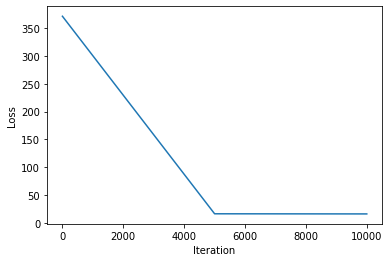

In [ ]:
w, error = calWeightGD(x_train_set, y_train_set, x_validation, y_validation , 50000, 0.01, True)
error

early stop!!
Finished training after {} iter: 47029


19.238901795751964

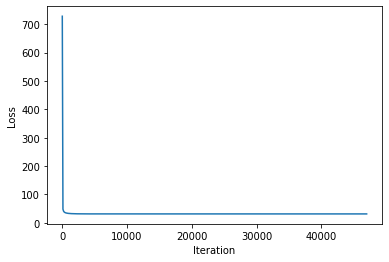

In [ ]:
w, error = calWeightAdagrad(x_train_set, y_train_set, x_validation, y_validation , 50000, 2, True)
error

* **18 features**
* 18

early stop!!
Finished training after {} iter: 5366
early stop!!
Finished training after {} iter: 9752
early stop!!
Finished training after {} iter: 3580
early stop!!
Finished training after {} iter: 4028
early stop!!
Finished training after {} iter: 2778
early stop!!
Finished training after {} iter: 10770
early stop!!
Finished training after {} iter: 4630
early stop!!
Finished training after {} iter: 10862
early stop!!
Finished training after {} iter: 4042
early stop!!
Finished training after {} iter: 5018


18.061341344939116

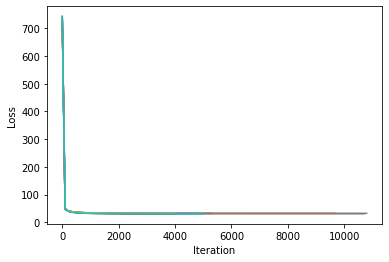

In [ ]:
error_val = []
for i in range(10):
  x_tra, y_tra, x_val, y_val = shullfeData(x, y)
  w, error = calWeightAdagrad(x_tra, y_tra, x_val, y_val , 100000, 2, True)
  error_val.append(error)
np.mean(error_val, axis = 0)

* **16 features**
* 17

In [ ]:
index = [0,1,2,3,4,5,6,7,8,9,11,12,13,14,15,17]
error_val = []
for i in range(10):
  x_tra, y_tra, x_val, y_val = shullfeData(x, y)
  w, error = selectFeatureNum(x_tra, y_tra, x_val, y_val, index)
  error_val.append(error)
np.mean(error_val, axis = 0)

* **14 Features**
17.23

In [ ]:
index = [0,1,2,3,5,6,7,8,9,11,12,13,14,15]
error_val = []
for i in range(10):
  x_tra, y_tra, x_val, y_val = shullfeData(x, y)
  w, error = selectFeatureNum(x_tra, y_tra, x_val, y_val, index)
  error_val.append(error)
np.mean(error_val, axis = 0)

early stop!!
Finished training after {} iter: 5273
early stop!!
Finished training after {} iter: 4678
early stop!!
Finished training after {} iter: 8596
early stop!!
Finished training after {} iter: 5209
early stop!!
Finished training after {} iter: 8542
early stop!!
Finished training after {} iter: 2993
early stop!!
Finished training after {} iter: 1318
Finished training after {} iter: 99999
early stop!!
Finished training after {} iter: 6899
early stop!!
Finished training after {} iter: 2697


17.235012076074746

* **13 features**
17.26

In [ ]:
index = [0,1,3,5,6,7,8,9,11,12,13,14,15]
error_val = []
for i in range(15):
  x_tra, y_tra, x_val, y_val = shullfeData(x, y)
  w, error = selectFeatureNum(x_tra, y_tra, x_val, y_val, index)
  error_val.append(error)
np.mean(error_val, axis = 0)

early stop!!
Finished training after {} iter: 2341
early stop!!
Finished training after {} iter: 10595
early stop!!
Finished training after {} iter: 12220
early stop!!
Finished training after {} iter: 2290
early stop!!
Finished training after {} iter: 7343
early stop!!
Finished training after {} iter: 3689
early stop!!
Finished training after {} iter: 2416
early stop!!
Finished training after {} iter: 1481
early stop!!
Finished training after {} iter: 2230
early stop!!
Finished training after {} iter: 6073
early stop!!
Finished training after {} iter: 86628
early stop!!
Finished training after {} iter: 2359
early stop!!
Finished training after {} iter: 4655
early stop!!
Finished training after {} iter: 5050
early stop!!
Finished training after {} iter: 2433


17.260900479846548

* **11 features**
17.17

In [ ]:
index = [1,5,6,7,8,9,11,12,13,14,15]
error_val = []
for i in range(10):
  x_tra, y_tra, x_val, y_val = shullfeData(x, y)
  w, error = selectFeatureNum(x_tra, y_tra, x_val, y_val, index)
  error_val.append(error)
np.mean(error_val, axis = 0)

early stop!!
Finished training after {} iter: 9278
early stop!!
Finished training after {} iter: 6288
early stop!!
Finished training after {} iter: 3886
early stop!!
Finished training after {} iter: 11302
early stop!!
Finished training after {} iter: 4402
early stop!!
Finished training after {} iter: 9817
early stop!!
Finished training after {} iter: 2913
early stop!!
Finished training after {} iter: 5004
early stop!!
Finished training after {} iter: 4306
early stop!!
Finished training after {} iter: 9871


17.17007243388966

* **8 Features**
17.28

In [ ]:
index = [1,5,7,8,9,12,13,14]
error_val = []
for i in range(10):
  x_tra, y_tra, x_val, y_val = shullfeData(x, y)
  w, error = selectFeatureNum(x_tra, y_tra, x_val, y_val, index)
  error_val.append(error)
np.mean(error_val, axis = 0)

early stop!!
Finished training after {} iter: 4590
early stop!!
Finished training after {} iter: 10795
early stop!!
Finished training after {} iter: 40321
early stop!!
Finished training after {} iter: 1526
early stop!!
Finished training after {} iter: 3671
early stop!!
Finished training after {} iter: 2166
early stop!!
Finished training after {} iter: 5533
early stop!!
Finished training after {} iter: 5476
early stop!!
Finished training after {} iter: 40069
early stop!!
Finished training after {} iter: 14500


17.288383810533993

* **7 Features**
17.54

In [ ]:
index = [1,5,7,8,9,12,13]
error_val = []
for i in range(15):
  x_tra, y_tra, x_val, y_val = shullfeData(x, y)
  w, error = selectFeatureNum(x_tra, y_tra, x_val, y_val, index)
  error_val.append(error)
np.mean(error_val, axis = 0)

early stop!!
Finished training after {} iter: 3481
early stop!!
Finished training after {} iter: 2557
early stop!!
Finished training after {} iter: 2069
early stop!!
Finished training after {} iter: 3649
early stop!!
Finished training after {} iter: 2399
early stop!!
Finished training after {} iter: 4128
early stop!!
Finished training after {} iter: 1039
early stop!!
Finished training after {} iter: 5077
early stop!!
Finished training after {} iter: 41804
early stop!!
Finished training after {} iter: 1768
early stop!!
Finished training after {} iter: 3134
early stop!!
Finished training after {} iter: 4582
early stop!!
Finished training after {} iter: 37664
early stop!!
Finished training after {} iter: 3760
early stop!!
Finished training after {} iter: 3698


17.549814295451483

* **6 Features**
16.42 <= Best

In [25]:
index = [5,7,8,9,12,13]
error_val = []
w_val = []
for i in range(15):
  x_tra, y_tra, x_val, y_val = shullfeData(x, y)
  w, error = selectFeatureNum(x_tra, y_tra, x_val, y_val, index)
  w_val.append(w)
  error_val.append(error)
error_val = np.mean(error_val, axis = 0)
w_val = np.mean(w_val, axis = 0)
error_val

early stop!!
Finished training after {} iter: 3663
early stop!!
Finished training after {} iter: 1471
early stop!!
Finished training after {} iter: 2129
early stop!!
Finished training after {} iter: 3440
early stop!!
Finished training after {} iter: 37666
early stop!!
Finished training after {} iter: 37094
early stop!!
Finished training after {} iter: 2495
early stop!!
Finished training after {} iter: 7740
early stop!!
Finished training after {} iter: 3010
early stop!!
Finished training after {} iter: 37351
early stop!!
Finished training after {} iter: 35173
early stop!!
Finished training after {} iter: 34449
early stop!!
Finished training after {} iter: 4925
early stop!!
Finished training after {} iter: 4872
early stop!!
Finished training after {} iter: 2166


17.040771665040797

* **5 Features**
17.35

In [ ]:
index = [5,7,8,9,13]
error_val = []
for i in range(10):
  x_tra, y_tra, x_val, y_val = shullfeData(x, y)
  w, error = selectFeatureNum(x_tra, y_tra, x_val, y_val, index)
  error_val.append(error)
np.mean(error_val, axis = 0)

early stop!!
Finished training after {} iter: 2214
early stop!!
Finished training after {} iter: 1698
early stop!!
Finished training after {} iter: 2030
early stop!!
Finished training after {} iter: 2758
early stop!!
Finished training after {} iter: 31877
early stop!!
Finished training after {} iter: 14537
early stop!!
Finished training after {} iter: 2614
early stop!!
Finished training after {} iter: 2039
early stop!!
Finished training after {} iter: 6313
early stop!!
Finished training after {} iter: 2248


17.35841935553822

* **4 Features**
18.18

In [ ]:
index = [5,7,8,9]
error_val = []
for i in range(10):
  x_tra, y_tra, x_val, y_val = shullfeData(x, y)
  w, error = selectFeatureNum(x_tra, y_tra, x_val, y_val, index)
  error_val.append(error)
np.mean(error_val, axis = 0)

early stop!!
Finished training after {} iter: 1236
early stop!!
Finished training after {} iter: 1174
early stop!!
Finished training after {} iter: 3627
early stop!!
Finished training after {} iter: 1873
early stop!!
Finished training after {} iter: 1181
early stop!!
Finished training after {} iter: 25936
early stop!!
Finished training after {} iter: 7402
early stop!!
Finished training after {} iter: 27731
early stop!!
Finished training after {} iter: 2625
early stop!!
Finished training after {} iter: 3988


18.199272219648133

* **Only PM2.5**
19.

In [ ]:
index = [9]
error_val = []
for i in range(10):
  x_tra, y_tra, x_val, y_val = shullfeData(x, y)
  w, error = selectFeatureNum(x_tra, y_tra, x_val, y_val, index)
  error_val.append(error)
np.mean(error_val, axis = 0)

early stop!!
Finished training after {} iter: 531
early stop!!
Finished training after {} iter: 1060
early stop!!
Finished training after {} iter: 8900
early stop!!
Finished training after {} iter: 742
early stop!!
Finished training after {} iter: 9107
early stop!!
Finished training after {} iter: 9111
early stop!!
Finished training after {} iter: 8647
early stop!!
Finished training after {} iter: 8837
early stop!!
Finished training after {} iter: 1303
early stop!!
Finished training after {} iter: 567


19.093570296005737

# **Select Complex Model**

In [ ]:
def select_model(x,y,index, pow):
  x_choose = np.empty([x.shape[0], 9*len(index)])
  g = 0

  # xi
  for i in index:
    x_choose[:,g*9:g*9+9] = x[:, i*9:i*9+9]
    g +=1

  # xi^2
  for i in index:
    x_choose = np.append(x_choose, np.power(x[:, i*9:i*9+9], pow), axis = 1)

  # xi^2
  for i in index:
    x_choose = np.append(x_choose, np.power(x[:, i*9:i*9+9], pow+1), axis = 1)

  #pm2.5 x9*xi
  #for i in index:
    #k = np.multiply(x[:, 9*9:9*9+9], x[:, i*9:i*9+9])
    #x_choose = np.append(x_choose, k, axis = 1)
  y_choose = y
  return x_choose, y_choose

* **18 features**
17.

In [ ]:
#index = [5,7,8,9,12,13]
index = range(18)
w_val = []
error_val = []
for i in range(1):
  x_tra, y_tra, x_val, y_val = shullfeData(x, y)
  x_train_n, y_train_n = select_model(x_tra, y_tra, index, 2)
  x_val_n, y_val_n = select_model(x_val, y_val, index, 2)
  w, error = calWeightAdagrad(x_train_n, y_train_n, x_val_n, y_val_n, 120000, 1)
  w_val.append(w)
  error_val.append(error)
error_val = np.mean(error_val, axis = 0)
w_val = np.mean(w_val, axis = 0)
error_val

Finished training after {} iter: 119999


21.908663342016787

* **Only pm2.5**
* 17.34

In [ ]:
x_train_n, y_train_n = select_model(x_train_set, y_train_set, [9], 2)
x_val_n, y_val_n = select_model(x_validation, y_validation, [9], 2)
w_p, error = calWeightAdagrad(x_train_n, y_train_n, x_val_n, y_val_n, 40000, 2)
error

early stop!!
Finished training after {} iter: 33065


17.341780769293017

* **power 3** <= Not very good
* 16.6

In [ ]:
index = [1,5,7,8,9,12,13]
pow = 3
x_train_n, y_train_n = select_model(x_train_set, y_train_set, index, pow)
x_val_n, y_val_n = select_model(x_validation, y_validation, index, pow)
w_p, error = calWeightAdagrad(x_train_n, y_train_n, x_val_n, y_val_n, 40000, 2)
error

early stop!!
Finished training after {} iter: 27665


17.040375076097074

* **power 2**
* 16.41

In [ ]:
index = [1,5,7,8,9,12,13]
pow = 2
x_train_n, y_train_n = select_model(x_train_set, y_train_set, index, pow)
x_validation_n, y_validation_n = select_model(x_validation, y_validation, index, pow)
w_7f_p2, error = calWeight(x_train_n, y_train_n, x_validation_n, y_validation_n , 20000, 2)
error

early stop!!
Finished training after {} iter: 12900


16.410347150456058

* **power 2, 4 features**
* 16.16

In [ ]:
index = [5,7,8,9]
pow = 2
x_train_n, y_train_n = select_model(x_train_set, y_train_set, index, pow)
x_validation_n, y_validation_n = select_model(x_validation, y_validation, index, pow)
w_4f_p2, error = calWeight(x_train_n, y_train_n, x_validation_n, y_validation_n, 20000, 2)
error

early stop!!
Finished training after {} iter: 5056


16.044871409387746

# **Training**
![alt text](https://drive.google.com/uc?id=1xIXvqZ4EGgmxrp7c9r0LOVbcvd4d9H4N)
![alt text](https://drive.google.com/uc?id=1S42g06ON5oJlV2f9RukxawjbE4NpsaB6)
![alt text](https://drive.google.com/uc?id=1BbXu-oPB9EZBHDQ12YCkYqtyAIil3bGj)

(和上圖不同處: 下面的 code 採用 Root Mean Square Error)

因為常數項的存在，所以 dimension (dim) 需要多加一欄；eps 項是避免 adagrad 的分母為 0 而加的極小數值。

每一個 dimension (dim) 會對應到各自的 gradient, weight (w)，透過一次次的 iteration (iter_time) 學習。

In [ ]:
dim = 18 * 9 + 1
w = np.zeros([dim, 1])
x_ = np.concatenate((np.ones([12 * 471, 1]), x), axis = 1).astype(float) #5256x162+1
learning_rate = 400
iter_time = 1000
adagrad = np.zeros([dim, 1])
eps = 0.0000000001
y_loss = list()
x_iter = list()
for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(x_, w) - y, 2))/471/12)#rmse
    if(t%500==0):
        print(str(t) + ":" + str(loss))
        y_loss.append(loss)
        x_iter.append(t)
    gradient = 2 * np.dot(x_.transpose(), np.dot(x_, w) - y) #dim*1
    adagrad += gradient ** 2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps)
np.save('weight.npy', w)
w #163x1

In [ ]:
def calWeight(x, y, iter_time, learning_rate):
  dim_col, dim_row = x.shape
  w = np.zeros([dim_row+1, 1])
  x_ = np.concatenate((np.ones([dim_col, 1]), x), axis = 1).astype(float)
  adagrad = np.zeros([dim_row+1, 1])
  eps = 0.0000000001
  y_loss = list()
  x_iter = list()
  for t in range(iter_time):
      loss = np.sqrt(np.sum(np.power(np.dot(x_, w) - y, 2))/dim_col)#rmse
      if(t%5==0):
          #print(str(t) + ":" + str(loss))
          y_loss.append(loss)
          x_iter.append(t)
      gradient = 2 * np.dot(x_.transpose(), np.dot(x_, w) - y) #dim*1
      adagrad += gradient ** 2
      w = w - learning_rate * gradient / np.sqrt(adagrad + eps)
  #np.save('weight.npy', w)
  #print('w:',w.shape) #163x1
  #pltloss(y_loss,x_iter,learning_rate)
  return x_iter, y_loss

# Learning Rate

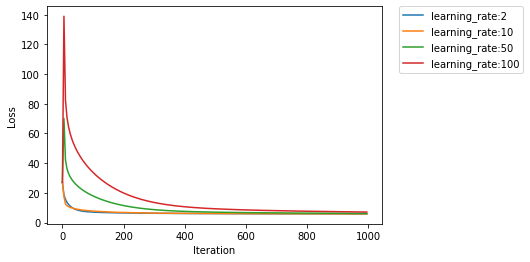

In [ ]:
for i in [2,10,50,100]:
  x_iter, y_loss = calWeight(x,y, 1000, i)
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# **Regularization**

In [ ]:
x_axis = []
y_axis = []
for lamb in [0.1, 0.5]:
  w,error = calWeight(x_train_set, y_train_set, x_validation, y_validation, 20000, 2, lamb)
  print('lambda:'+ str(lamb) +', error:',error)
  x_axis.append(lamb)
  y_axis.append(error)
plt.plot(x_axis,y_axis)


# **9hour v.s. 9*18 hours**

---


*   18*9 hours better than 9 hours
16.35 (all features) > 17.17  (only pm2.5)



* **18*9 hours**
* 16.35

In [ ]:
w, cost = calWeightAdagrad(x_train_set, y_train_set, x_validation, y_validation,10000,2)
cost

early stop!!
Finished training after {} iter: 6138


16.043204404583243

* **9 hour**
* 17.17

In [ ]:
nine_x = x_train_set[:, 9*9:9*9+9]
nine_y = y_train_set
nine_x_val = x_validation[:, 9*9:9*9+9]
nine_y_val = y_validation
w, cost = calWeightAdagrad(nine_x, nine_y, nine_x_val, nine_y_val, 10000, 2)
cost

early stop!!
Finished training after {} iter: 9200


17.176209031072602

# **Checking xth hours is better**

---



* **x-9hours**
* 9 hours is better than just 5 hours (means do not need to select)
  

In [ ]:
def xth_hour_select(n, x, y):
  row = int(x.shape[1]/9)
  x_valid = np.empty([x.shape[0] , row*(9-n+1)], dtype = float)
  y_valid = y
  for j in range(len(x)):
    for i in range(int(x.shape[1]/9)):
      x_valid[j, i*(9-n+1):i*(9-n+1)+(9-n+1)] = x[j, i*9+n-1 : i*9+9 ]
  print(str(n)+'-9hr x:',x_valid.shape) #1131x90 (18xn)
  print(str(n)+'-9hr y:',y_valid.shape)
  return x_valid, y_valid

In [ ]:
x_train_5, y_train_5 = xth_hour_select(5, x_train_set, y_train_set)
x_val_5, y_val_5 = xth_hour_select(5, x_validation, y_validation)
x_iter, y_loss = calWeight(x_train_5, y_train_5, 1000, 2)
plt.plot(x_iter, y_loss, label='5 hrs')
x_iter, y_loss = calWeight(x_train_set, y_train_set, 1000,2)
plt.plot(x_iter, y_loss, label='9 hrs')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim([5, 15])

In [ ]:
w, cost = calWeightAdagrad(x_train_5, y_train_5, x_val_5, y_val_5,10000,2)
cost

early stop!!
Finished training after {} iter: 6532


16.100450176300733

In [ ]:
w, cost = calWeightAdagrad(x_train_set, y_train_set, x_validation, y_validation,10000,2)
cost

early stop!!
Finished training after {} iter: 6138


16.043204404583243

# **Combine Feature Selection & Hours Selection**

* **7 features & 7-9hours**
* 18.64999243794835

In [ ]:
index = [1,5,7,8,9,12,13]
x_train_7, y_train_7 = select_feature(x_train_set, y_train_set, index)
x_7f_7h, y_7f_7h = xth_hour_select(7, x_train_7, y_train_7) #7-9 hours
w_7f_7h = calWeight(x_7f_7h, y_7f_7h, 5000, 5)
x_validation_7, y_validation_7 = select_feature(x_validation, y_validation,index)
x_val_7f_7h, y_val_7f_7h = xth_hour_select(7,x_validation_7, y_validation_7)
error_7f_7h = calCost(x_val_7f_7h, w_7f_7h, y_val_7f_7h)
error_7f_7h

* **7 features & 1-9 hours**
* **15.629102226937615** <= best

In [ ]:
index = [1,5,7,8,9,12,13]
x_train_7, y_train_7 = select_feature(x_train_set, y_train_set, index)
x_7f_7h, y_7f_7h = xth_hour_select(1, x_train_7, y_train_7) #7-9 hours
w_7f_7h = calWeight(x_7f_7h, y_7f_7h, 5000, 5)
x_validation_7, y_validation_7 = select_feature(x_validation, y_validation,index)
x_val_7f_7h, y_val_7f_7h = xth_hour_select(1,x_validation_7, y_validation_7)
error_7f_7h = calCost(x_val_7f_7h, w_7f_7h, y_val_7f_7h)
error_7f_7h

* **6 features & 6-9hours** 
* 15.776883276246048


In [ ]:
index = [5,7,8,9,12,13]
x_train_6, y_train_6 = select_feature(x_train_set, y_train_set, index)
x_6f_6h, y_6f_6h = xth_hour_select(6, x_train_6, y_train_6) #5-9 hours
w_6f_6h = calWeight(x_6f_6h, y_6f_6h, 5000, 5)
x_validation_6, y_validation_6 = select_feature(x_validation, y_validation,index)
x_val_6f_6h, y_val_6f_6h = xth_hour_select(6,x_validation_6, y_validation_6)
error_6f_6h = calCost(x_val_6f_6h, w_6f_6h, y_val_6f_6h)
error_6f_6h

* **6 features & 1-9 hours**
*15.646430118735402

In [ ]:
index = [5,7,8,9,12,13]
x_train_6, y_train_6 = select_feature(x_train_set, y_train_set, index)
x_6f_6h, y_6f_6h = xth_hour_select(1, x_train_6, y_train_6) #5-9 hours
w_6f_6h = calWeight(x_6f_6h, y_6f_6h, 5000, 5)
x_validation_6, y_validation_6 = select_feature(x_validation, y_validation,index)
x_val_6f_6h, y_val_6f_6h = xth_hour_select(1,x_validation_6, y_validation_6)
error_6f_6h = calCost(x_val_6f_6h, w_6f_6h, y_val_6f_6h)
error_6f_6h

# **Testing**
![alt text](https://drive.google.com/uc?id=1165ETzZyE6HStqKvgR0gKrJwgFLK6-CW)

載入 test data，並且以相似於訓練資料預先處理和特徵萃取的方式處理，使 test data 形成 240 個維度為 18 * 9 + 1 的資料。

In [ ]:
# testdata = pd.read_csv('gdrive/My Drive/hw1-regression/test.csv', header = None, encoding = 'big5')
testdata = pd.read_csv('./test.csv', header = None, encoding = 'big5')
test_data = testdata.iloc[:, 2:]
test_data[test_data == 'NR'] = 0
test_data = test_data.to_numpy() #4320x9
test_x = np.empty([240, 18*9], dtype = float) #=> 4320/18 = 240
for i in range(240):
    test_x[i, :] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)  # i col <= 18x9
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
test_x = np.concatenate((np.ones([240, 1]), test_x), axis = 1).astype(float)
test_x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


array([[ 1.        , -0.24447681, -0.24545919, ..., -0.67065391,
        -1.04594393,  0.07797893],
       [ 1.        , -1.35825331, -1.51789368, ...,  0.17279117,
        -0.10906991, -0.48454426],
       [ 1.        ,  1.5057434 ,  1.34508393, ..., -1.32666675,
        -1.04594393, -0.57829812],
       ...,
       [ 1.        ,  0.3919669 ,  0.54981237, ...,  0.26650729,
        -0.20275731,  1.20302531],
       [ 1.        , -1.8355861 , -1.8360023 , ..., -1.04551839,
        -1.13963133, -1.14082131],
       [ 1.        , -1.35825331, -1.35883937, ...,  2.98427476,
         3.26367657,  1.76554849]])

In [ ]:
test_x.shape

(240, 163)

# **Prediction**
說明圖同上

![alt text](https://drive.google.com/uc?id=1165ETzZyE6HStqKvgR0gKrJwgFLK6-CW)

有了 weight 和測試資料即可預測 target。

In [ ]:
w = np.load('weight.npy')
ans_y = np.dot(test_x, w)
ans_y

In [ ]:
x_test_n, y_test_n = select_model(test_x, 0, range(0,18), 2)
x_test_n = np.concatenate((np.ones([x_test_n.shape[0], 1]), x_test_n), axis = 1).astype(float)
test_y_sel = np.dot(x_test_n, w_p)
saveSubmit(test_y_sel)

In [ ]:
test_y_sel = np.dot(test_x, w_)

In [ ]:
index = [5,7,8,9,12,13]

x_test_n, y_test_n = select_feature(test_x, 0, index)
x_test_n = np.concatenate((np.ones([x_test_n.shape[0], 1]), x_test_n), axis = 1).astype(float)
test_y_sel = np.dot(x_test_n, w)
saveSubmit(test_y_sel)

['id', 'value']
['id_0', 7.4175029585183685]
['id_1', 14.908990326372358]
['id_2', 33.63618705341647]
['id_3', 9.447507015458783]
['id_4', 32.53397886763405]
['id_5', 19.768902458146787]
['id_6', 24.22370821678336]
['id_7', 36.93745324834247]
['id_8', 29.637684475167255]
['id_9', 57.08827146879386]
['id_10', 23.17564881447217]
['id_11', 18.449845052445752]
['id_12', 52.74325604732219]
['id_13', 58.179853787051464]
['id_14', 17.14024796310087]
['id_15', 6.102772194552456]
['id_16', 29.86803659530532]
['id_17', 69.94294945157462]
['id_18', 2.560608660635419]
['id_19', 17.590004082174982]
['id_20', 42.08174552581414]
['id_21', 65.45898953691243]
['id_22', 4.171730926753144]
['id_23', 17.413552173397694]
['id_24', 12.773899665193884]
['id_25', 34.21403307785464]
['id_26', 10.75934309485582]
['id_27', 79.08048064223264]
['id_28', 9.43191037504447]
['id_29', 62.20470669607639]
['id_30', 20.310693101492575]
['id_31', 8.726922455468696]
['id_32', 4.33199347833841]
['id_33', 43.93033532836484]


* **2 power**

In [ ]:
index = [1,5,7,8,9,12,13]
pow = 2
x_train_n, y_train_n = select_model(x_train_set, y_train_set, index, pow)
w_7f_p2 = calWeight(x_train_n, y_train_n, 7000, 5)
x_test_n, test_y = select_model(test_x, 0, index, pow)
x_test_n = np.concatenate((np.ones([x_test_n.shape[0], 1]), x_test_n), axis = 1).astype(float)
test_y_sel = np.dot(x_test_n, w_7f_p2)

In [ ]:
index = [5,7,8,9]
pow = 2
x_test_n, test_y = select_model(test_x, 0, index, pow)
x_test_n = np.concatenate((np.ones([x_test_n.shape[0], 1]), x_test_n), axis = 1).astype(float)
test_y_sel = np.dot(x_test_n, w_4f_p2)

In [ ]:
x_test_n, test_y = select_model(test_x, 0, [9], 2)
x_test_n = np.concatenate((np.ones([x_test_n.shape[0], 1]), x_test_n), axis = 1).astype(float)
test_y_sel = np.dot(x_test_n, w_p)
saveSubmit(test_y_sel)

* **7 features**

In [ ]:
x_train_set_7, y_train_set_7 = select_feature(x_train_set, y_train_set, [1,5,7,8,9,12,13])
w = calWeight(x_train_set_7,y_train_set_7,5000,0.5)
test_x_sel, test_y_sel = select_feature(test_x, y, [1,5,7,8,9,12,13])
test_x_7f_9h = np.concatenate((np.ones([test_x_sel.shape[0], 1]), test_x_sel), axis = 1).astype(float)
test_y_sel = np.dot(test_x_7f_9h, w)
test_y_sel.shape

* **6 features**

In [ ]:
x_train_set_6, y_train_set_6 = select_feature(x_train_set, y_train_set, [5,7,8,9,12,13])
w = calWeight(x_train_set_6,y_train_set_6,2000,0.5)
test_x_sel, test_y_sel = select_feature(test_x, y, [5,7,8,9,12,13])
test_x_6f_9h = np.concatenate((np.ones([test_x_sel.shape[0], 1]), test_x_sel), axis = 1).astype(float)
test_y_sel = np.dot(test_x_6f_9h, w)
test_y_sel.shape

# **Save Prediction to CSV File**


In [ ]:
import csv

In [ ]:
def saveSubmit(ans_y):
  with open('submit.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'value']
    print(header)
    csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), ans_y[i][0]]
        csv_writer.writerow(row)
        print(row)

In [ ]:
saveSubmit(test_y_sel)

相關 reference 可以參考:

Adagrad :
https://youtu.be/yKKNr-QKz2Q?list=PLJV_el3uVTsPy9oCRY30oBPNLCo89yu49&t=705 

RMSprop : 
https://www.youtube.com/watch?v=5Yt-obwvMHI 

Adam
https://www.youtube.com/watch?v=JXQT_vxqwIs 


以上 print 的部分主要是為了看一下資料和結果的呈現，拿掉也無妨。另外，在自己的 linux 系統，可以將檔案寫死的的部分換成 sys.argv 的使用 (可在 terminal 自行輸入檔案和檔案位置)。

最後，可以藉由調整 learning rate、iter_time (iteration 次數)、取用 features 的多寡(取幾個小時，取哪些特徵欄位)，甚至是不同的 model 來超越 baseline。

Report 的問題模板請參照 : https://docs.google.com/document/d/1s84RXs2AEgZr54WCK9IgZrfTF-6B1td-AlKR9oqYa4g/edit